# cuda:4

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
M=6000
Signal Length M=6000
maxmin = 8.998889692334945
std = 2.25


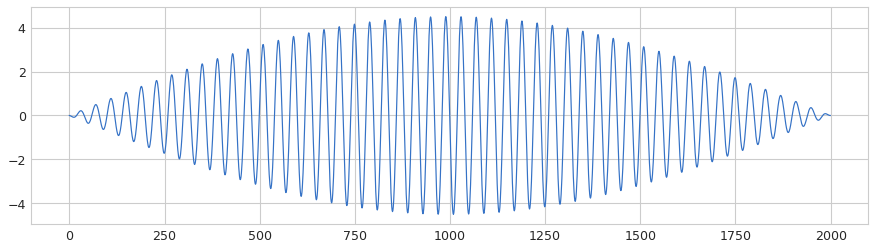

Trainlength = 4000


In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:5'

signal = []
Tm = 500
Tc = 5
Mg = 1.5
A = 3.
phase_m = 1.*np.pi/2
t= 0.
for n in range(3000*2):
    t += .25/2 
    mod = Mg*np.cos(2*np.pi*t/Tm + phase_m)
    carrier = A*np.sin(2*np.pi*t/Tc)
    s = mod*carrier
    signal.append(s)
signal = np.array(signal)

FREERUN = 0
M = signal.shape[0]-FREERUN
N = 35
K = 1
L = 1
RF = .5
TEST = 2000
LEAD = 100
BURNIN = 2000
REG = 1e-12
TRAINLENGTH = M-TEST
print(f'M={M}')
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50
print(f'Signal Length M={M}')
print(f'maxmin = {MINMAX}' )
print(f'std = {STD}')
plt.figure(figsize=(15,4))
plt.plot(signal[-2000:])
plt.show()
print(f'Trainlength = {TRAINLENGTH}')

In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
fpath = 'Dicts0/S3/diag_S3_long.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts0/S3/models_S3_long.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [5]:
#with open('Dicts/diagX.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsX.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

In [6]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### The predictions below are purely from the refinement process in the paper.  There is no handpicking of models.

In [7]:
size = [1000,800,600,400,300,200,100,50,40,30,28,26,24,22,20,18,16,14,12,10]

[116 120 119 126 122 109 132 114 113 126 122 100 118 102 103 100 101 121
 108 124]


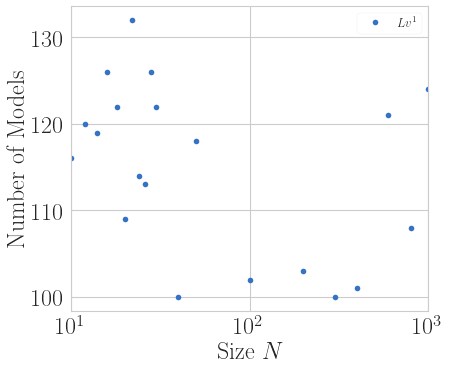

In [8]:
mean_errors = []
num_models = []


    
for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
#np.save('num_modelsS3',num_models)

mname = ['num_modelsS3.npy']
labels = ['$Lv^{1}$','$Lv^{3}$','L3D','MG']
for i in range(len(mname)):
    num_models = np.load(mname[i])
    print(num_models[::-1])
    plt.semilogx(size[::-1],num_models[::-1],'o',label=labels[i])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.legend(loc='upper right')
plt.show()

N=1000   Error = 0.024 KL-div = 0.384 E*kl=0.009
N=800   Error = 0.014 KL-div = 0.307 E*kl=0.004
N=600   Error = 0.037 KL-div = 0.305 E*kl=0.011
N=400   Error = 0.038 KL-div = 0.211 E*kl=0.008
N=300   Error = 0.025 KL-div = 0.287 E*kl=0.007
N=200   Error = 0.033 KL-div = 0.319 E*kl=0.010
N=100   Error = 0.02 KL-div = 0.377 E*kl=0.008
N=50   Error = 0.042 KL-div = 0.508 E*kl=0.022
N=40   Error = 0.07 KL-div = 0.184 E*kl=0.013
N=30   Error = 0.051 KL-div = 0.195 E*kl=0.010
N=28   Error = 0.034 KL-div = 0.288 E*kl=0.010
N=26   Error = 0.087 KL-div = 0.808 E*kl=0.070
N=24   Error = 0.069 KL-div = 0.277 E*kl=0.019
N=22   Error = 0.042 KL-div = 0.218 E*kl=0.009
N=20   Error = 0.055 KL-div = 0.397 E*kl=0.022
N=18   Error = 0.033 KL-div = 0.279 E*kl=0.009
N=16   Error = 0.09 KL-div = 0.542 E*kl=0.049
N=14   Error = 0.069 KL-div = 0.385 E*kl=0.027
N=12   Error = 0.07 KL-div = 0.603 E*kl=0.042
N=10   Error = 0.086 KL-div = 0.252 E*kl=0.022


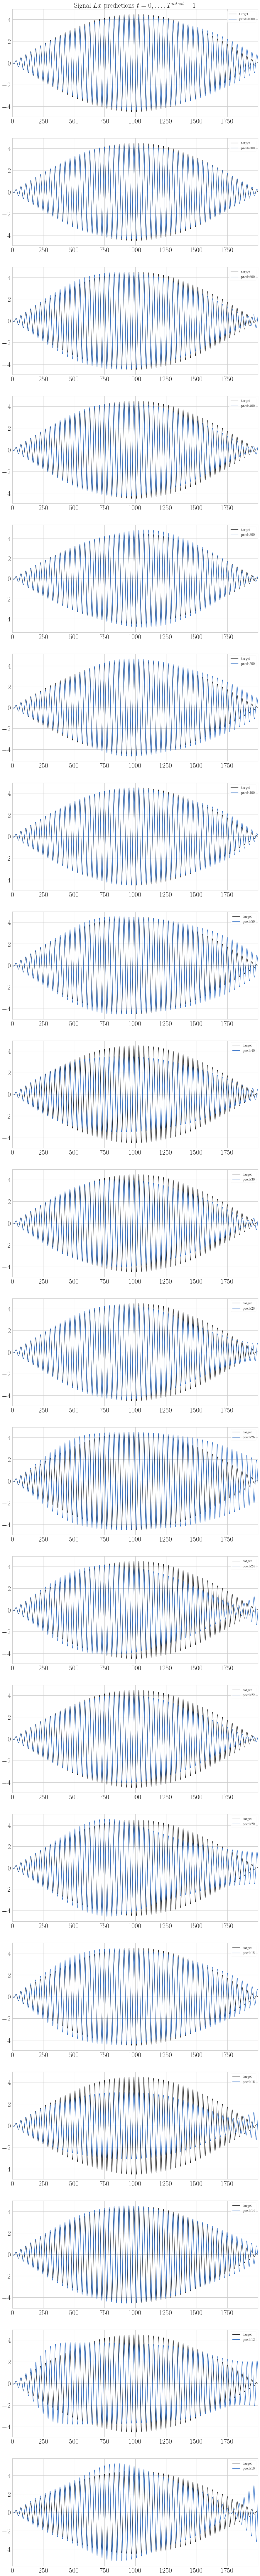

In [8]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {error_testset.round(3)} KL-div = {kl:.3f} E*kl={Ekl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Get indicated rank to reduce to

Targeted reduced rank for N=1000 is 36
Value v= 19 Tolerance 1e-19 Rho A 0.733
Alpha 0.6696304379162432 --- Gamma 1.0

Targeted reduced rank for N=800 is 36
Value v= 19 Tolerance 1e-19 Rho A 0.733
Alpha 0.6696304379162432 --- Gamma 1.0

Targeted reduced rank for N=600 is 33
Value v= 19 Tolerance 1e-19 Rho A 0.695
Alpha 0.6970960163537671 --- Gamma 1.0

Targeted reduced rank for N=400 is 36
Value v= 19 Tolerance 1e-19 Rho A 0.744
Alpha 0.6709558843122198 --- Gamma 1.0

Targeted reduced rank for N=300 is 38
Value v= 19 Tolerance 1e-19 Rho A 0.752
Alpha 0.6569568403406965 --- Gamma 1.0

Targeted reduced rank for N=200 is 34
Value v= 19 Tolerance 1e-19 Rho A 0.742
Alpha 0.6969640795602043 --- Gamma 1.0

Targeted reduced rank for N=100 is 35
Value v= 19 Tolerance 1e-19 Rho A 0.746
Alpha 0.6509429199781283 --- Gamma 1.0

Targeted reduced rank for N=50 is 30
Value v= 19 Tolerance 1e-19 Rho A 0.733
Alpha 0.6696304379162432 --- Gamma 1.0

Targeted reduced rank for N=40 is 27
Value v= 19 Toleran

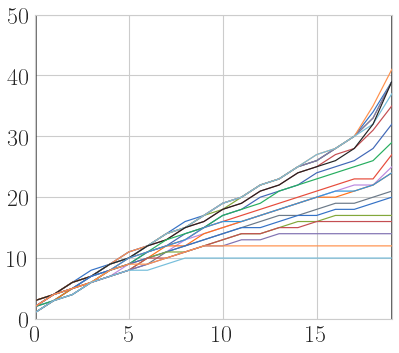

In [9]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

all_ranks = []
K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
np.zeros(len(size),)
plt.figure()
for n in size[:]:
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    if(v+1 == 20):
        ave_rank = (rkc[v]+rkc[v-1])//2
    else:
        ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
    print(f'Alpha {a} --- Gamma {g}\n')
    all_ranks.append(ave_rank)
plt.ylim(0,50)
plt.show()



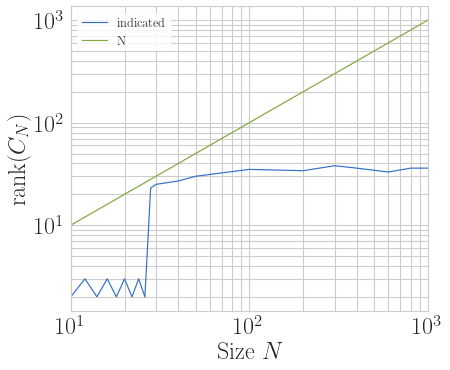

In [10]:
rsize = size[::-1]

plt.loglog(rsize[:],all_ranks[::-1], label='indicated')
plt.loglog(rsize[:],rsize[:], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

In [11]:
mean_error = []
for i in size:
    err = dict_diag[str(i)]['meanError']
    mean_error.append(err)
    print(f'N={i}   number {err}')

N=1000   number 0.15002868829551452
N=800   number 0.14655470159246667
N=600   number 0.14982190768603554
N=400   number 0.1547576321273375
N=300   number 0.14778679241106682
N=200   number 0.1585659881423786
N=100   number 0.17243509627425624
N=50   number 0.17036370980299903
N=40   number 0.18146314993256138
N=30   number 0.17947246674583264
N=28   number 0.19394947849686756
N=26   number 0.1867084515084068
N=24   number 0.1825860848850051
N=22   number 0.1976007393307897
N=20   number 0.19628596521437422
N=18   number 0.2081535451683
N=16   number 0.2093913810608862
N=14   number 0.20909232542036973
N=12   number 0.2202790143973174
N=10   number 0.21803596800315964


### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$

In [12]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
T = M + FREERUN
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = 30
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(size[i])]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,BURNIN:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')

k=N=30 Trainingset min=0.969  threshold=0.921  Location=1965
k=N=30 Trainingset min=0.969  threshold=0.921  Location=1970
k=N=30 Trainingset min=0.966  threshold=0.918  Location=1812
k=N=30 Trainingset min=0.967  threshold=0.918  Location=1852
k=N=30 Trainingset min=0.969  threshold=0.921  Location=1893
k=N=30 Trainingset min=0.969  threshold=0.921  Location=1965
k=N=30 Trainingset min=0.967  threshold=0.919  Location=1970
k=N=30 Trainingset min=0.969  threshold=0.921  Location=1966
k=N=30 Trainingset min=0.96  threshold=0.912  Location=253
k=N=30 Trainingset min=0.965  threshold=0.917  Location=1853
k=N=30 Trainingset min=0.969  threshold=0.921  Location=1794
k=N=30 Trainingset min=0.955  threshold=0.907  Location=1874
k=N=30 Trainingset min=0.967  threshold=0.919  Location=1575
k=N=30 Trainingset min=0.967  threshold=0.918  Location=1873
k=N=30 Trainingset min=0.965  threshold=0.917  Location=1959
k=N=30 Trainingset min=0.964  threshold=0.916  Location=1915
k=N=30 Trainingset min=0.9

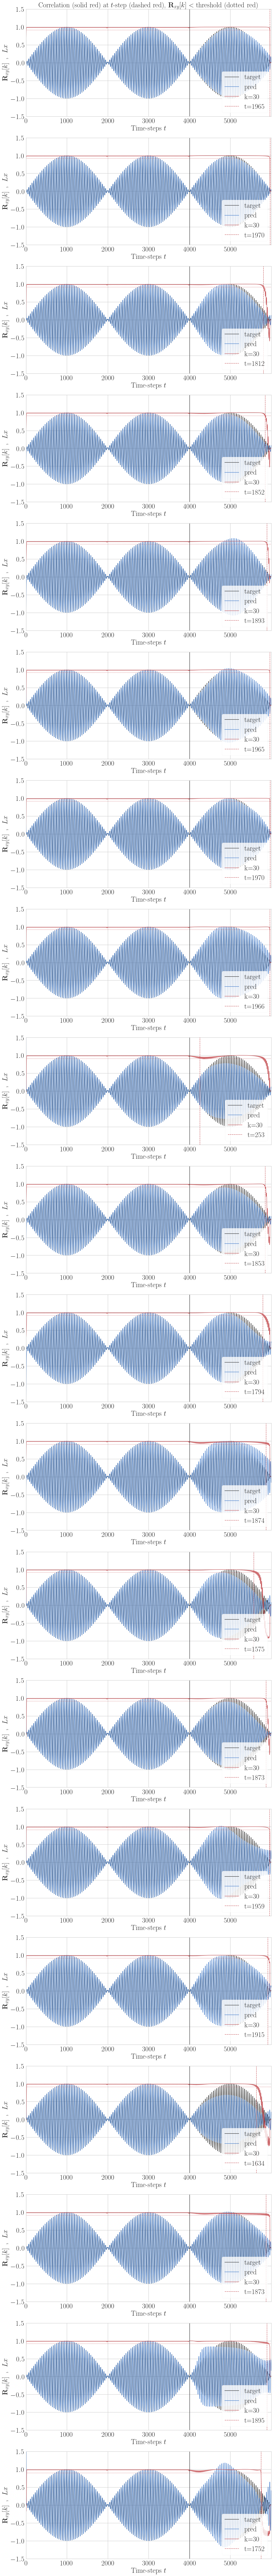

In [13]:
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    pred = dict_models[str(size[n])]['Preds']
    axs[n].set_ylim(-1.5,1.5)
    axs[n].plot(signal[:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,:TRAINLENGTH+TEST], color='r', label=f'k={k}')
    axs[n].axvline(TRAINLENGTH+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(TRAINLENGTH,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()